In [1]:
import sys
import os
import time
import warnings
sys.path.append(os.path.abspath(os.path.join('../../')))
warnings.filterwarnings("ignore")

In [2]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
from evaluation import full_evaluate

In [3]:
# Reading the dataset
df = pd.read_csv("../../datasets/final_features_dataset.csv")

# Separating features and target variable
X = df.drop(columns=['is_fraud', 'Unnamed: 0'])
y = df['is_fraud']

# Splitting the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Convert data to arrays if they are not already
X_train = X_train.values if isinstance(X, pd.DataFrame) else X_train
y_train = y_train.values if isinstance(y, pd.Series) else y_train

In [4]:
# Defining the hyperparameter search space
hyperparameter_space = {
    "tol": [0, 1],
    "C": [0.1, 100],
    "fit_intercept": [-1, 1],
    "intercept_scaling": [1, 5],
    "class_weight": [-1, 1],
    "max_iter": [100, 10000],
    "multi_class": [0, 3],
    "warm_start": [-1, 1],
    "l1_ratio": [0, 1]
}


# Define fitness function to evaluate model performance
def fitness(hyperparameters, get_model = False):
    """
    Function to evaluate the fitness of decision tree model with given hyperparameters.

    Args:
    hyperparameters (list): List of hyperparameter values.
    get_model (bool): If True, returns the model only, otherwise returns the fitness score.

    Returns:
    float or DecisionTreeClassifier: Fitness score if get_model=False, else the model itself.
    """
    # Check if hyperparameters are within defined ranges
    for i, value in enumerate(hyperparameters):
        param_name = list(hyperparameter_space.keys())[i]
        range_min = hyperparameter_space[param_name][0]
        range_max = hyperparameter_space[param_name][1]
        if not (range_min <= value <= range_max):
            return float('-inf') # Penalize if hyperparameters are out of range

    # Determine multi_class
    multi_class = 'auto'
    if round(hyperparameters[6]) == 2: 
        multi_class = 'ovr'
    elif round(hyperparameters[6]) == 3: 
        multi_class = 'multinomial'

    # Create logistic regression model with specified hyperparameters
    model = LogisticRegression(
        tol = hyperparameters[0],
        C = hyperparameters[1],
        fit_intercept =  hyperparameters[2]>0,
        intercept_scaling = hyperparameters[3],
        class_weight = 'balanced' if  hyperparameters[4]>0 else None,
        max_iter =  round(hyperparameters[5]),
        multi_class = multi_class,
        warm_start = hyperparameters[7]>0,
        l1_ratio = hyperparameters[8],
        random_state=0
    )

    # If only model is requested, return the model
    if get_model:
        print('Best parameters', {
            "tol": hyperparameters[0],
            "C": hyperparameters[1],
            "fit_intercept":  hyperparameters[2]>0,
            "intercept_scaling": hyperparameters[3],
            "class_weight": 'balanced' if  hyperparameters[4]>0 else None,
            "max_iter":  round(hyperparameters[5]),
            "multi_class": multi_class,
            "warm_start": hyperparameters[7]>0,
            "l1_ratio": hyperparameters[8],
        })
        return model
    else:
        # Initialize cross-validation
        cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)
        cv_results = []
        
        # Perform cross-validation
        for train_index, test_index in cv.split(X_train, y_train):
            X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
            y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

            # smote oversampling
            sm = SMOTE()
            X_train_fold, y_train_fold = sm.fit_resample(X_train_fold, y_train_fold)
            
            # Fit the model
            model = model.fit(X_train_fold, y_train_fold)
            
            # Make predictions
            y_train_pred = model.predict(X_train_fold)
            y_test_pred = model.predict(X_test_fold)
            
            # Calculate evaluation metrics
            f1_train = f1_score(y_train_fold, y_train_pred)
            f1_test = f1_score(y_test_fold, y_test_pred)

            # Store results
            cv_results.append({'f1_train': f1_train, 'f1_test': f1_test})
            
        # Extracting F1 scores for training, testing, and validation sets from cross-validation results
        f1_train = np.array([fold["f1_train"] for fold in cv_results])
        f1_test = np.array([fold["f1_test"] for fold in cv_results])

        # Initialize the score variable to negative infinity
        score = float("-inf")
        score = f1_test.mean()
        return score

New best 0.0
New best 0.06981375550396607
New best 0.0708347272410783
New best 0.0717411636174865
New best 0.07192105117863119
New best 0.07276514479094634


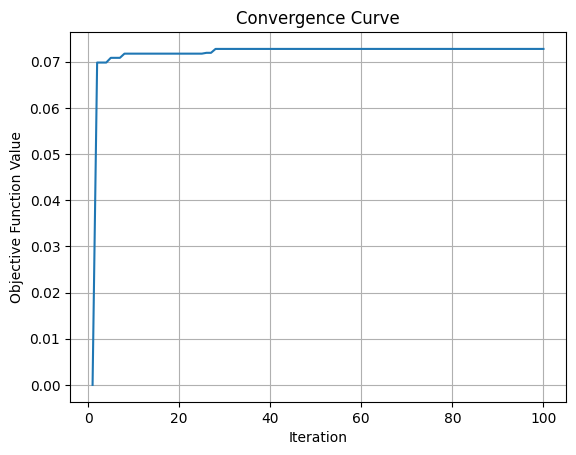

Best parameters {'tol': 0.0, 'C': 0.1, 'fit_intercept': False, 'intercept_scaling': 1.0, 'class_weight': None, 'max_iter': 100, 'multi_class': 'auto', 'warm_start': False, 'l1_ratio': 0.0}
Training set Counter({0: 8780, 1: 8780}) Test set Counter({0: 2927, 1: 132}) Validation set Counter({0: 2927, 1: 132})
Training set Counter({0: 8780, 1: 8780}) Test set Counter({0: 2927, 1: 132}) Validation set Counter({0: 2927, 1: 132})
Training set Counter({0: 8780, 1: 8780}) Test set Counter({0: 2927, 1: 132}) Validation set Counter({0: 2927, 1: 132})
Training set Counter({0: 8781, 1: 8781}) Test set Counter({0: 2926, 1: 132}) Validation set Counter({0: 2927, 1: 132})
Fold 1: (Train F1: 0.53, Test F1: 0.06, Validation F1: 0.07, Precision: 0.04, Recall: 0.42, Accuracy: 0.51).
Fold 2: (Train F1: 0.53, Test F1: 0.07, Validation F1: 0.07, Precision: 0.04, Recall: 0.43, Accuracy: 0.50).
Fold 3: (Train F1: 0.58, Test F1: 0.07, Validation F1: 0.07, Precision: 0.04, Recall: 0.49, Accuracy: 0.45).
Fold 4: 

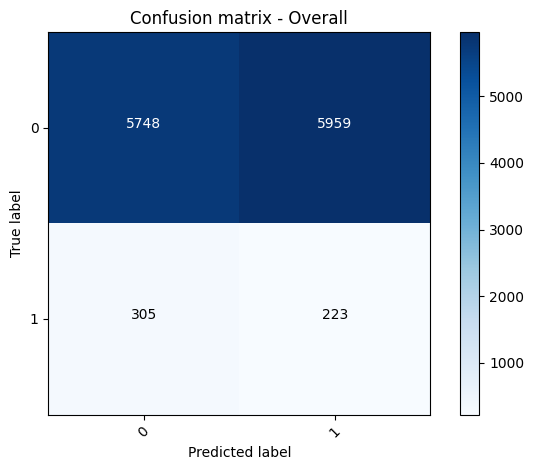

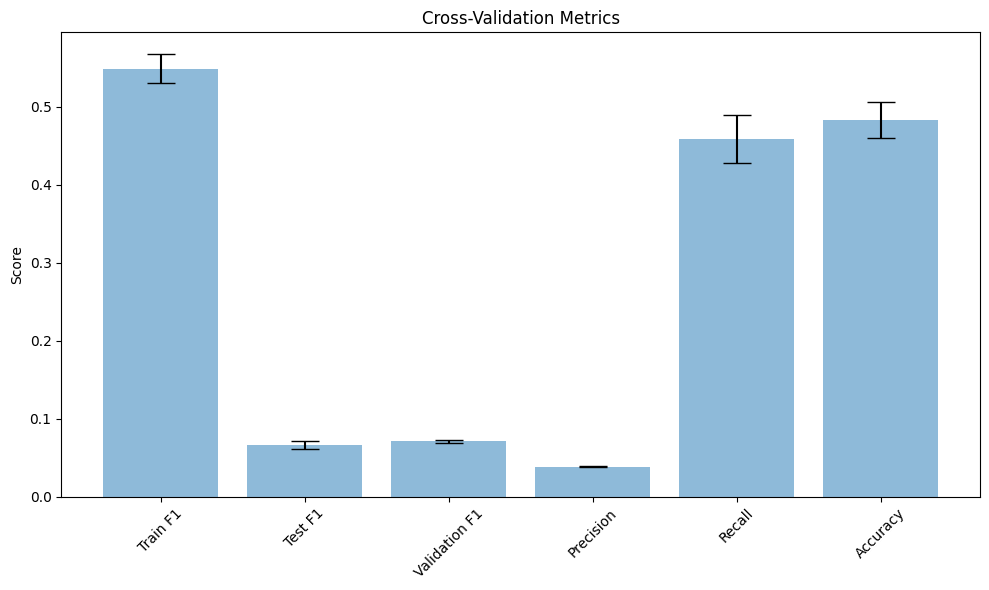

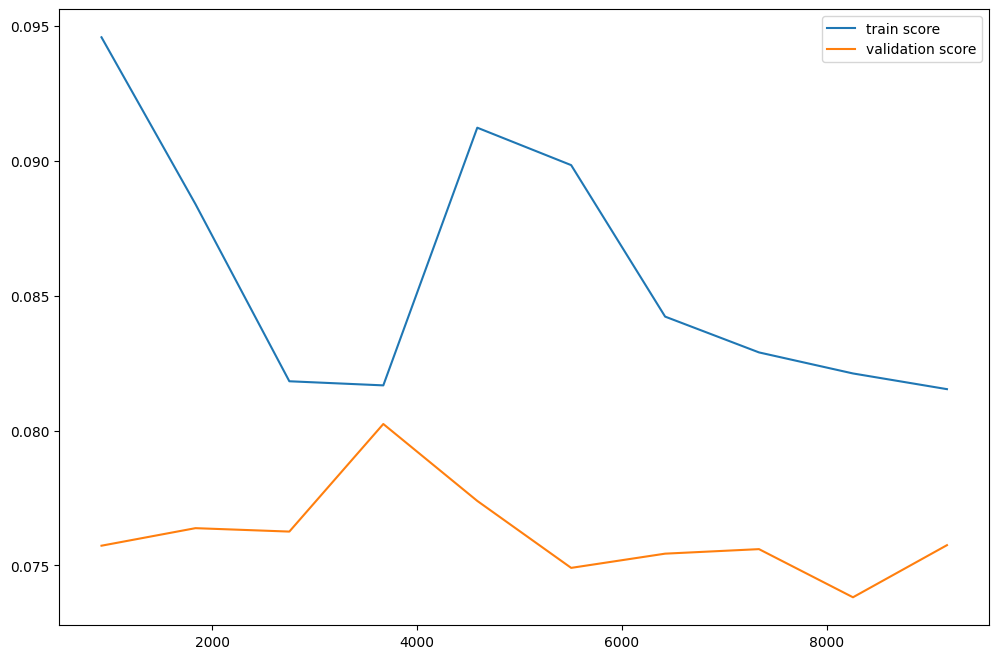

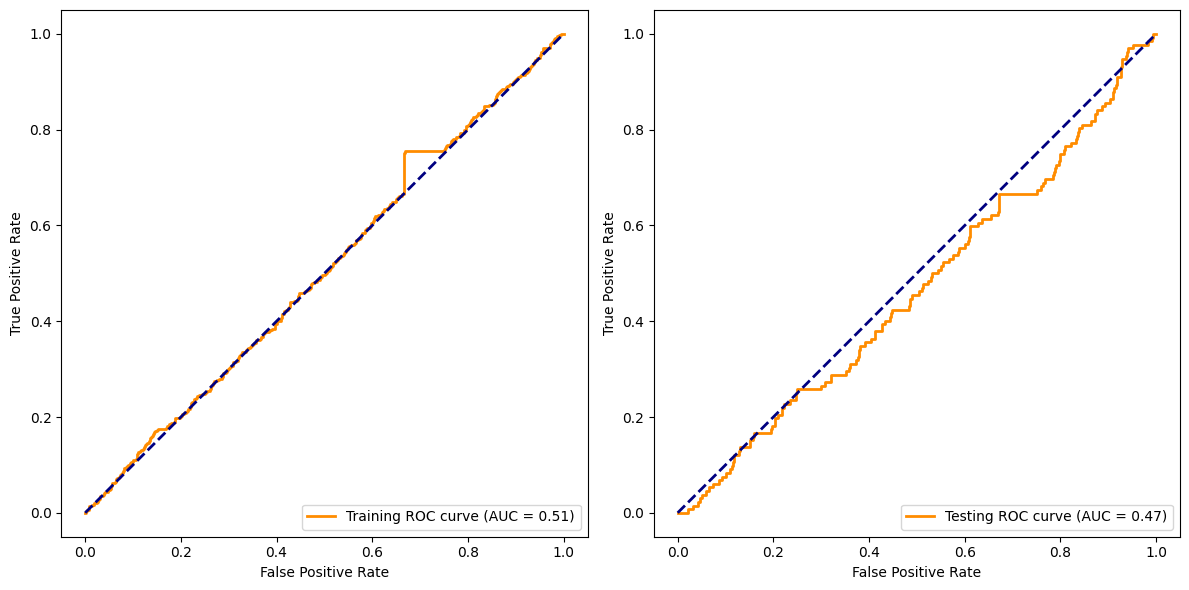

213.19964241981506 seconds


In [5]:
# Measure the start time for the optimization process
starting = time.time()

# Perform hyperparameter optimization using the Harris Hawks Optimization algorithm
# The `full_evaluate` function evaluates the fitness of each individual (hawk) in the population
# by calling the `fitness` function defined earlier
# `fitness` is the function that computes the fitness score for each set of hyperparameters
# `X` is the feature dataset
# `y` is the target variable
# `hyperparameter_space` defines the search space for hyperparameters
# `sampling` is an optional parameter to specify the sampling method
# `max_iter` specifies the maximum number of iterations for the HHO algorithm
# `pop_size` specifies the population size for each iteration
full_evaluate.full_evaluate(fitness, X, y, hyperparameter_space, sampling='smote', max_iter=100, pop_size=5)

# Measure the time taken for optimization by calculating the difference between the start time and the current time
exec_time = time.time() - starting

# Print the execution time in seconds
print(exec_time, "seconds")